<h1><center> TP2: Pandas, data analysis library </center></h1>
The goal of this TP is to help you become familiar with the 'pandas' class in Python. This library is often used for data analysis and is convenient for manipulation tool. We consider a case-study based on a dataset that contains information about bookings of two hotels. Hotel 1 is a resort hotel and Hotel 2 is a city hotel in Portugal. The dataset was released by https://www.sciencedirect.com/science/article/pii/S2352340918315191.

We first list the basic functions in pandas. PART 1 aims at using pandas as a visualization tool to give a better understanding of the data. PART 2 shows how easy it is to combine "pandas" dataframes and "sklearn" models to build additional features and predict. 

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Short intro into pandas

In [2]:
data = pd.read_csv("bookings.csv") 

In [ ]:
data.tail(5) # print last 5 entries of the dataset

In [ ]:
data.columns # print column names

This dataset contains information about bookings of two hotels. Hotel 1 is a resort hotel and Hotel 2 is a city hotel in Portugal. The dataset was released by https://www.sciencedirect.com/science/article/pii/S2352340918315191.

There are 32 columns in this dataset:

1. **hotel** -- one of the two hotels
2. **is_canceled** -- Value indicating if the booking was canceled (1) or not (0)
3. **lead_time** -- Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
4. ....

For the full description of each column please see: https://www.kaggle.com/jessemostipak/hotel-booking-demand

In [ ]:
data['country'] # we can also print each column of the dataset

In [ ]:
data['country'].unique() # list all unique values in the column

In [ ]:
data.count()

This dataset contains 119390 different reservations. Some of the reservations have missing values.


In [ ]:
data.values # A data frame can be converted into a numpy array by calling the values attribute:data['country'].unique()

However this array cannot be directly fed into a scikit-learn model.

1. the values are heterogeneous (strings for categories, integers, and floating point numbers)
2. some feature values are missing

# Predicting cancellation: Part I -- visualization

**Our goal** The purpose of this part is to provide a few examples of data visualization combining ```pandas```, ```matplotlib```, ```seaborn```. 

Pandas allows to manipulate the dataset in a very convenient manner. 

As a first visualization task let us understand which months have the most number of cancellations.
We start by creating a new dataset that contains the information that we would like to plot.

In [ ]:
'''
We create two datasets for each hotel .groupby("arrival_date_month") will group observations by the month 
and .count() function will simply count the amount of reservations for each month
'''
n_reserv_H1 = data.loc[(data["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["hotel"].count()
n_cancel_H1 = data.loc[(data["hotel"] == "Resort Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

n_reserv_H2 = data.loc[(data["hotel"] == "City Hotel")].groupby("arrival_date_month")["hotel"].count()
n_cancel_H2 = data.loc[(data["hotel"] == "City Hotel")].groupby("arrival_date_month")["is_canceled"].sum()

In [ ]:
n_reserv_H1.head() # again we can have a look at the top 5 entries

In [ ]:
n_reserv_H1['April'] # number of reservation for Resort Hotel for April

In [ ]:
n_cancel_H1['April'] # number of cancelled reservations for Resort Hotel for April

In [ ]:
# Finally, we gather everything together
data_visualH1 = pd.DataFrame({"hotel": "Resort Hotel",
                                "month": list(n_reserv_H1.index),
                                "n_booking": list(n_reserv_H1.values),
                                "n_cancel": list(n_cancel_H1.values)})
data_visualH2 = pd.DataFrame({"hotel": "City Hotel",
                                "month": list(n_reserv_H2.index),
                                "n_booking": list(n_reserv_H2.values),
                                "n_cancel": list(n_cancel_H2.values)})
data_visual = pd.concat([data_visualH1, data_visualH2], ignore_index=True)

# notice how easy it is to add a new column. We simply write the following
data_visual["percent_cancel"] = data_visual["n_cancel"] / data_visual["n_booking"] * 100 # percent of cancelations

In [ ]:
data_visual.head() # our final dataset

In [ ]:
plt.figure(figsize=(6, 6))
sns.barplot(x = "month", y = "percent_cancel" , hue="hotel",
            hue_order = ["Resort Hotel", "City Hotel"], data=data_visual)
plt.title("Cancelations per month")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Cancelations [%]")
plt.legend()
plt.show()

The above plot is informative, but the ordering of the months is not natural.

**Question 1.** Propose a solution that will re-order the barplot above based on the standard ordering of the months in a calendar year. 

Hint: use ```pd.Categorical()``` function of pandas.

*That we did, but ```pd.to_datetime()``` would have been a more logical function to use?*

In [ ]:
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']
data_visual['month'] = pd.Categorical(data_visual['month'], categories=months_order, ordered=True)

plt.figure(figsize=(6, 6))
sns.barplot(x = "month", y = "percent_cancel" , hue="hotel",
            hue_order = ["Resort Hotel", "City Hotel"], data=data_visual)
plt.title("Cancelations per month")
plt.xticks(rotation=45)
plt.xlabel("Month")
plt.ylabel("Cancelations [%]")
plt.legend()
plt.show()

**Question 2.** Provide an interpretation of the observations made in the above plot.

The cancellation rate is always higher for the city hotel compared to the resort hotel. 

Additionally, there is a clear seasonal pattern in the resort hotel, where cancellations are higher in the summer and lower in the winter. In the city hotel, cancellations do fluctuate over time, but to a lesser extent. 

This suggests that the causes of cancellations are different in these two hotels.

**Question 3.** What is the most and the second most common country of origin for reservations for each hotel?

In [ ]:
country_counts = data.groupby(['hotel', 'country']).size().reset_index(name='count')

top_countries = country_counts.sort_values(['hotel', 'count'], ascending=[True, False]).groupby('hotel').head(2)

top_countries

The most frequent country of origin for both hostels is Portugal. The second most frequent country of origin is France for the city hotel and Great Britain for the resort hotel.

**Question 4.** Plot the number of cancelations for repeated and not repeated guests for both hotels.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

sns.countplot(
    x="is_canceled",
    hue='is_repeated_guest',
    data=data[data['hotel'] == 'Resort Hotel'],
    ax=ax1)
ax1.set_title("Resort Hotel")

sns.countplot(
    x="is_canceled", 
    hue='is_repeated_guest',
    data=data[data['hotel'] == 'City Hotel'],
    ax=ax2)
ax2.set_title("City Hotel")

plt.tight_layout()
plt.savefig('cancelations_repeated_hotel.png', format='png')
plt.show()

Most guests in these two hotels are not repeated, while the repeated guests are less likely to cancel.

In [ ]:
data_req = data[(data['hotel'] == 'City Hotel')].groupby(['total_of_special_requests', 'is_canceled']).size().unstack(level=1)
data_req.plot(kind='bar', stacked=True, figsize=(6,6))
plt.title('Special Request vs Cancellation in City Hotel')
plt.xlabel('Number of Special Request', fontsize=10)
plt.xticks(rotation=300)
plt.ylabel('Count', fontsize=10)
plt.savefig('cancelations_city_hotel.png', format='png')

Most of the reservations in the city hotel have no special requests and the cancellation in this case is almost 50/50. However, when special requests are made, the cancellation rate is significantly lower.

**Question 5.** Make the same plot for Resort Hotel and provide your conclusions.

In [ ]:
data_req = data[(data['hotel'] == 'Resort Hotel')].groupby(['total_of_special_requests', 'is_canceled']).size().unstack(level=1)
data_req.plot(kind='bar', stacked=True, figsize=(6,6))
plt.title('Special Request vs Cancellation in Resort Hotel')
plt.xlabel('Number of Special Request', fontsize=10)
plt.xticks(rotation=300)
plt.ylabel('Count', fontsize=10)
plt.savefig('cancelations_resort_hotel.png', format='png')

For the resort hotel, a similar correlation is observed between cancellations and the number of special requests: as customers make special requests, they appear significantly less likely to cancel. However, this pattern is less pronounced than for city hotels, as the cancellation rate is not evenly split (50/50) for those with zero special requests.

# Predicting cancellations: Part II -- ML

**Our goal** The main message here is -- do not re-invent the wheel. The following few lines of code highlight the simplicity with which we can combine ```pandas``` dataframes and ```sklearn``` models. By learning a few simple tools (i.e. ```pipeline```, ```gridsearchcv```) our code becomes readable, compact, and can be used to build extra features on top of it.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [ ]:
numeric_features = ["lead_time", "arrival_date_week_number", "total_of_special_requests"]
categorical_features = ["hotel", "market_segment", "deposit_type", "customer_type"]
features = numeric_features + categorical_features
X = data.drop(["is_canceled"], axis=1)[features]
y = data["is_canceled"]

Before using any ML algorithms from sklearn we need to handle the missing values. There is no unique answer to how to deal with missing values in your dataset. We will use one of the simplest possible approaches. If the missing feature is numerical, we replace it with a zero. If the missing feature is categorical, we are going to define a new category and call it ```Not defined```.

In [ ]:
numeric_transformer = SimpleImputer(strategy="constant", fill_value=0) # to deal with missing numeric data
categorical_transformer = Pipeline(steps=[
                                    ("imputer", SimpleImputer(strategy="constant", fill_value="Not defined")),
                                    ("onehot", OneHotEncoder(handle_unknown='ignore'))]) # to deal with missing categorical data 
preproc = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                          ("cat", categorical_transformer, categorical_features)])

**Question:** What is ```OneHotEncoder()```? Why do we use it in our case?

```OneHotEncoder()``` is a function from ```sklearn``` that converts each modality of a categorical variable into a binary format, creating a dummy variable that takes a value of 1 if the observation belongs to that category and 0 if it does not. This encoding is necessary for feeding categorical data to many estimators, notably linear models and SVMs with standard kernels.

Now consider a situation where you want to try a number of different models and for each model you want to make some cross-validation to select the best hyperparameters. On top of that you want to preprocess the data so that you feed something meaningfull into each method. The next chunk of code shows how to do it.

In [ ]:
models = [("logreg", LogisticRegression(max_iter=5000))]
grids = {"logreg" : {'logreg__C': np.logspace(-4, 4, 9, base=2)}}

for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), (name, model)])
    clf = GridSearchCV(pipe, grids[name], cv=3)
    clf.fit(X, y)
    print('Results for {}'.format(name))
    print(clf.cv_results_)

**The story!**
As a data scientist advising the hotel, you are asked to help the management carry out the following task: The hotel has the option to offer its guests parking spots for a fee, but this feature does not seem to be known to many of the hotel guests. Therefore, in order to make the potential guests aware of paid parking availability, the hotel would like to send out SMS notifications to its customers. However, since sending such notifications is not free, the hotel management believes that it is best to send the message only to a subset of the customers who are most likely to be interested in a parking spot. You are asked to devise a model which, for each new reservation, gives a YES/NO answer as to whether or not the hotel should send the parking SMS notification to the customer who has made the reservation.

**Problem** Explore your data to help the management and construct a prediction algorithm, using the above template as an inspiration. 

**Warning!** Note that some columns are not actually avaiable at the moment of reservation. For instance, the target column ```is_canceled``` from the previous part clearly cannot be observed at the moment when we need to decide to send the SMS.

## Introduction

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import classification_report, make_scorer, accuracy_score, balanced_accuracy_score, precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, r2_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler, ADASYN
import warnings

warnings.filterwarnings("ignore")

Nous cherchons à prédire la réservation d'une place de parking suite à l'envoi d'un SMS commercial. Nous allons utiliser pour cela les réservations déjà faites, correspondant à la variable ```required_car_parking_spaces```. Dans l'absolu, nous voudrions :
- Utiliser le *nombre* de places réservées, car il est préférable de cibler les clients susceptibles d'en réserver plusieurs.
- Intégrer le risque que le séjour soit annulé, car il est préférable de cibler les clients les plus susceptibles de venir.

Examinons donc la distribution conjointe des variables ```required_car_parking_spaces``` et ```is_canceled```. Nous constatons :
- Que les effectifs de personnes réservant plus d'une place sont très faibles.
- Que les personnes réservant une place de parking n'annulent jamais leur séjour.

Cela nous conduit à néglier le nombre de place réservées ainsi que le risque d'annulation, que les données ne permettront pas de prédire. Nous arrivons à une tâche d'apprentissage supervisé avec une classification binaire, avec des observations en nombre suffisant mais des données déséquilibrées, l'une des deux classes représentant $6,62 \%$ des observations seulement.

In [5]:
pd.crosstab(data['is_canceled'], data['required_car_parking_spaces'])

required_car_parking_spaces,0,1,2,3,8
is_canceled,,,,,
0,67750,7383,28,3,2
1,44224,0,0,0,0


Nous supposons que la décision d'envoyer un SMS est prise immédiatement après la réservation. Nous ignorons donc les statuts de réservation et d'annulation, en éliminant trois variables : ```is_canceled```, ```reservation_status``` et ```reservation_status_date```.

Dans le monde réel, on pourrait préférer envoyer les SMS à une date ultérieure, une semaine avant la date d'arrivée par exemple, en supposant que les clients sont davantage susceptibles de réserver une place au dernier moment. On éliminerait alors les observations pour lesquelles ```is_canceled``` est vraie ou ```reservation_status``` a changé avant la date présente.

Nous utiliserons toutes les autres variables, car il n'y a aucune raison à ce stade de penser que certaines sont plus prédictives que d'autres.

In [5]:
numeric_features = ["lead_time", 
                    "arrival_date_week_number", 
                    "arrival_date_day_of_month", 
                    "total_of_special_requests",
                    "adults", 
                    "children", 
                    "babies", 
                    "stays_in_week_nights", 
                    "stays_in_weekend_nights",
                    "previous_bookings_not_canceled",
                    "previous_cancellations",
                    "is_repeated_guest",
                    "booking_changes",
                    "agent",
                    "days_in_waiting_list",
                    "adr",
                    "company"]

categorical_features = ["hotel", 
                        "market_segment", 
                        "deposit_type", 
                        "customer_type", 
                        "meal", 
                        "country", 
                        "distribution_channel",
                        "reserved_room_type",
                        "assigned_room_type"]

features = numeric_features + categorical_features

X = data[features]
y = (data['required_car_parking_spaces'] > 0).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
numeric_transformer = SimpleImputer(strategy="constant", fill_value=0)

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Not defined")),
    ("onehot", OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Paramètre nécessaire pour certaines modèles
])

preproc = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)])

Prenons contact avec le problème en ajustant un premier modèle de régression logistique, avec la spécification la plus simple et les hyperparamètres habituels. Nous utilisons le score de ```balanced_accuracy``` devant le déséquilibre des données.

In [ ]:
pipe = Pipeline([
    ('preprocessor', preproc), 
    ('logreg', LogisticRegression(max_iter=15000))  
])

parameters = {'logreg__C': np.logspace(-10, 10, 21, base=2)}

clf = GridSearchCV(
    pipe,
    parameters,
    cv=3,
    scoring={'accuracy': 'accuracy', 'balanced_accuracy': 'balanced_accuracy'},
    refit='balanced_accuracy',
    n_jobs=-1,
    verbose=2
)

clf.fit(X_train, y_train)

logreg_results = pd.DataFrame(clf.cv_results_)
logreg_results.to_csv('logreg_results.csv', index=False)

In [ ]:
# logreg_results = pd.read_csv("logres_results.csv")

In [9]:
logreg_results[['param_logreg__C', 'mean_test_accuracy', 'mean_test_balanced_accuracy']]

,param_logreg__C,mean_test_accuracy,mean_test_balanced_accuracy
0,0.000977,0.937652,0.500862
1,0.001953,0.937673,0.501736
2,0.003906,0.937725,0.503096
3,0.007812,0.937725,0.504899
4,0.015625,0.937683,0.505974
5,0.031250,0.937599,0.506948
6,0.062500,0.937453,0.507654
7,0.125000,0.937442,0.508353
8,0.250000,0.937421,0.508577
9,0.500000,0.937432,0.508896


Les résultats ne dépendent pratiquement pas de l'hyperparamètre.

Best parameter: {'logreg__C': 1024.0}
Accuracy on test: 0.9378088617137114
Balanced accuracy on test: 0.5090624973951365


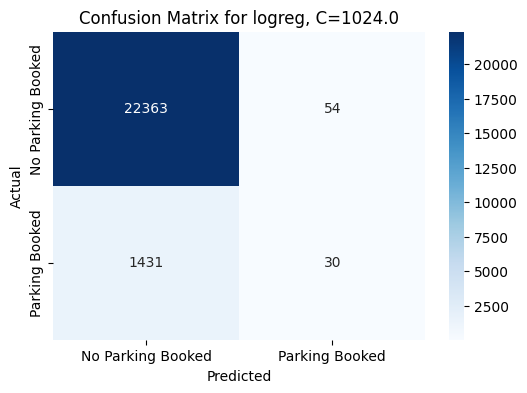

In [10]:
print("Best parameter:", clf.best_params_)

best_model = clf.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print("Accuracy on test:", accuracy)
print("Balanced accuracy on test:", balanced_accuracy)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Parking Booked', 'Parking Booked'],
            yticklabels=['No Parking Booked', 'Parking Booked'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix for logreg, C={clf.best_params_["logreg__C"]}')
plt.show()

Les résultats sont décevants. L'algorithme n'arrive à prédire la réservation d'aucune place de parking parmi plus de 20 000 clients. Il conduit à n'envoyer aucun SMS, ce qui n'est clairement pas l'objectif recherché. 

Face à cette difficulté, deux stratégies sont envisageables.
- La première consiste à optimiser les modèles afin d'arriver à mieux prédire les réservations, c'est-à-dire à générer davantage de vrais positifs, sans pour autant générer trop de faux positifs (les SMS n'auraient plus d'intérêt si trop de clients ne répondent pas).
- La seconde consiste à utiliser les probabilités d'appartenance aux classes plutôt que les classes prédites, en utilisant un seuil d'attribution inférieur à 0,5. Cela permet aussi d'individualiser la décision d'envoyer les SMS.

## Première approche : modèle prédictif optimal

Nous comparons 6 classes de modèles couvrant assez largement les possibilités de sklearn en matière de classification binaire, en utilisant les spécifications et les hyperparamètres habituels : 
- Les régressions logistiques comme modèle de référence
- Les *support vector machines* (avec un kernel radial qui donne généralement les meilleures performances)
- Les $k$ plus proches voisins
- Les forêts aléatoires
- Les *gradient boosting machines*
- Les perceptrons

Nous introduisons du *scaling* avec ```MaxAbsScaler()``` pour éviter de changer le signe des données numériques (qui sont toutes positives). 

Concernant les indicateurs de performance, deux nous intéressent particulièrement compte-tenu des difficultés précédentes à prédire la classe positive : le *recall* et la *precision*. Le premier correspond à la proportion des individus susceptibles de réserver une place de parking repérés par les algorithmes, le second à la proportion des individus repérés par l'algorithme susceptibles de réserver une place de parking. Le ciblerons donc le score f1, égal à la moyenne harmonique du *recall* et de la *precision* (et qui constitue un cas particulier du score f-beta, avec une pondération identique entre ces deux indicateurs). Nous souhaitons toutefois mesurer l'effet que la maximisation de ce score exerce sur les performances générales des modèles. Nous utiliserons la ```balanced_accuracy``` à cette fin.

In [11]:
def positive_class_count(y_true, y_pred):
    all_misclass = np.sum(y_pred == 1)
    return all_misclass
positive_class_counter = make_scorer(positive_class_count) # Pour dénombrer les prédictions positives

precision_scorer = make_scorer(precision_score, zero_division=0) # Pour supprimer les messages d'erreurs quand aucune classe positive n'est prédite

f_beta_scorer = make_scorer(fbeta_score, beta=1) # Pour créer le score F1

### Comparaison initiale

In [ ]:
# Sélection des modèles
models = [('logreg', LogisticRegression()),
          ('svc', SVC()),
          ('knn', KNeighborsClassifier()),
          ('rf', RandomForestClassifier()),
          ('hgbc', HistGradientBoostingClassifier()),
          ('mlp', MLPClassifier())
]

# Définition des espaces hyperparamétriques
grids = {'logreg' : {
             'logreg__C': np.logspace(-5, 5, 11, base=2),
             'logreg__max_iter': [15000]},
         'svc': {
             'svc__C': np.logspace(-4, 3, 8),
             'svc__kernel': ['rbf'],
             'svc__cache_size': [2000]},
         'knn' : {
             'knn__n_neighbors': [1, 2, 3, 4, 5],
             'knn__weights': ['uniform', 'distance']},
         'rf': {
             'rf__n_estimators': [100, 200, 300],
             'rf__max_depth': [None, 10, 20, 30],
             'rf__min_samples_split': [2, 5, 10],
             'rf__min_samples_leaf': [1, 2, 4]},
         'hgbc': {
             'hgbc__learning_rate': [0.01, 0.05, 0.1, 0.2],
             'hgbc__max_iter': [300],
             'hgbc__max_depth': [None, 10, 20, 30],
             'hgbc__min_samples_leaf': [1, 5, 10, 20],
             'hgbc__l2_regularization': [0, 0.1, 1, 10],
             'hgbc__early_stopping': [True],
             'hgbc__max_bins': [255]},
         'mlp': {
             'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100,100)],
             'mlp__activation': ['relu', 'tanh'],
             'mlp__learning_rate_init': [0.001, 0.01, 0.1],
             'mlp__max_iter': [750],
             'mlp__alpha': np.logspace(-5, -1, 5)}
}

# Recherche de la meilleure spécification
results = []
for name, model in models:
    pipe = Pipeline(steps=[('preprocessor', preproc), 
                           ('scaler', MaxAbsScaler()),
                           (name, model)
    ])
    clf = GridSearchCV(pipe, 
                       grids[name], 
                       cv=3,                 
                       scoring={'positive_pred': positive_class_counter,
                                'accuracy': 'accuracy', 
                                'balanced_accuracy': 'balanced_accuracy',
                                'precision': precision_scorer,
                                'recall': 'recall',
                                'beta_score': f_beta_scorer},
                       refit=False,
                       n_jobs=-1,
                       verbose=2)
    clf.fit(X_train, y_train)
    
    df = pd.DataFrame(clf.cv_results_)
    df['model'] = name
    df['type'] = type(clf.estimator)
    results.append(df)

# Agrégation des résultats
results = pd.concat(results, ignore_index=True)
results.to_csv('results.csv', index=False)

In [8]:
# results = pd.read_csv("results.csv")

In [15]:
# On affiche les performances moyennes par type de modèle type de modèle
results.groupby('model')[['mean_test_positive_pred', 'mean_test_recall', 'mean_test_precision', 'mean_test_beta_score', 'mean_test_balanced_accuracy']].max().reset_index()

,model,mean_test_positive_pred,mean_test_recall,mean_test_precision,mean_test_beta_score,mean_test_balanced_accuracy
0,hgbc,354.000000,0.104282,0.809481,0.176798,0.549696
1,knn,1901.000000,0.223174,0.341959,0.227950,0.587167
2,logreg,85.000000,0.020319,0.549325,0.038971,0.509411
3,mlp,2238.333333,0.256591,0.916667,0.235974,0.599336
4,rf,288.000000,0.071201,0.952381,0.124839,0.533295
5,svc,870.000000,0.129639,0.482943,0.179914,0.554558


On constate que les comportements des modèles varient significativement.
- ```hgbc```, ```logreg``` et ```svc``` ne seront pas exploitables car ils n'arrivent pas à prédire la classe positive
- Parmi les modèles restants, ```knn``` semble avoir le meilleur comportement

In [16]:
# On affiche les 15 meilleurs modèles d'après le score F1
top_15 = results.sort_values(by='mean_test_beta_score', ascending=False).head(15)
top_15[['model', 'params', 'mean_test_positive_pred', 'mean_test_recall', 'mean_test_precision', 'mean_test_beta_score', 'mean_test_balanced_accuracy']].fillna("-")

,model,params,mean_test_positive_pred,mean_test_recall,mean_test_precision,mean_test_beta_score,mean_test_balanced_accuracy
402,mlp,"{'mlp__activation': 'relu', 'mlp__alpha': 1e-0...",1678.666667,0.218304,0.257302,0.235974,0.588294
474,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",1747.333333,0.214945,0.244469,0.228698,0.585353
20,knn,"{'knn__n_neighbors': 1, 'knn__weights': 'dista...",1901.000000,0.223174,0.232982,0.227950,0.587167
19,knn,"{'knn__n_neighbors': 1, 'knn__weights': 'unifo...",1901.000000,0.223174,0.232982,0.227950,0.587167
462,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 1e-0...",1815.000000,0.217800,0.238420,0.227630,0.585742
22,knn,"{'knn__n_neighbors': 2, 'knn__weights': 'dista...",1887.666667,0.221159,0.232504,0.226670,0.586315
471,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",1647.000000,0.207389,0.249891,0.226614,0.583004
486,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",1677.000000,0.208564,0.246677,0.225982,0.583128
483,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.00...",1431.333333,0.194794,0.269371,0.224778,0.579900
426,mlp,"{'mlp__activation': 'relu', 'mlp__alpha': 0.00...",1540.666667,0.198489,0.258033,0.223391,0.580039


In [17]:
# Sélection des meilleurs modèles
best_model_idx = results['mean_test_balanced_accuracy'].idxmax()
best_model_row = results.loc[best_model_idx]
print("Best model based on balanced accuracy on test:")
print(best_model_row[['model', 'mean_test_positive_pred', 'mean_test_recall', 'mean_test_precision', 'mean_test_beta_score', 'mean_test_balanced_accuracy']])
print(best_model_row['params'])
print("\n")

best_model_idx = results['mean_test_beta_score'].idxmax()
best_model_row = results.loc[best_model_idx]
print("Best model based on beta score on test:")
print(best_model_row[['model', 'mean_test_positive_pred', 'mean_test_recall', 'mean_test_precision', 'mean_test_beta_score', 'mean_test_balanced_accuracy']])
print(best_model_row['params'])

Best model based on balanced accuracy on test:
model                                  mlp
mean_test_positive_pred        2238.333333
mean_test_recall                  0.256591
mean_test_precision               0.151865
mean_test_beta_score              0.190155
mean_test_balanced_accuracy       0.599336
Name: 494, dtype: object
{'mlp__activation': 'tanh', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate_init': 0.1, 'mlp__max_iter': 750}


Best model based on beta score on test:
model                                  mlp
mean_test_positive_pred        1678.666667
mean_test_recall                  0.218304
mean_test_precision               0.257302
mean_test_beta_score              0.235974
mean_test_balanced_accuracy       0.588294
Name: 402, dtype: object
{'mlp__activation': 'relu', 'mlp__alpha': 1e-05, 'mlp__hidden_layer_sizes': (100, 100), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 750}


Recall on test: 0.0
Precision on test: 0.0
F1 score on test: 0.0
Balanced accuracy on test: 0.5


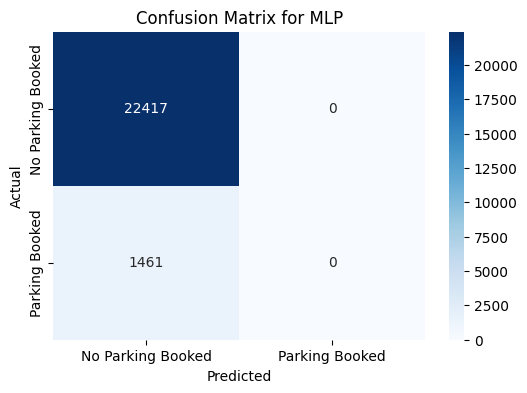

In [33]:
# Refit du meilleur modèle 1 (balanced accuracy)
pipe = Pipeline(steps=[('preprocessor', preproc),
                       ('scaler', MaxAbsScaler()),
                       ('mlp', MLPClassifier(
                           activation='tanh',
                           alpha=0.01,
                           hidden_layer_sizes=(100,),
                           learning_rate_init=0.1,
                           max_iter=750))
                        ])

best_model = pipe.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f_score = fbeta_score(y_test, y_pred, beta=1)
print("Recall on test:", recall)
print("Precision on test:", precision)
print("F1 score on test:", f_score)
print("Balanced accuracy on test:", balanced_accuracy)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Parking Booked', 'Parking Booked'],
            yticklabels=['No Parking Booked', 'Parking Booked'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for MLP')
plt.show()

Recall on test: 0.21492128678986996
Precision on test: 0.2554922701383238
F1 score on test: 0.23345724907063198
Balanced accuracy on test: 0.5870520249357299


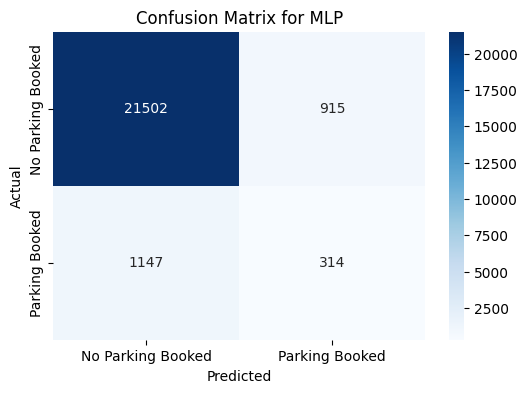

In [34]:
# Refit du meilleur modèle 2 (f1 score)
pipe = Pipeline(steps=[('preprocessor', preproc),
                       ('scaler', MaxAbsScaler()),
                       ('mlp', MLPClassifier(
                           activation='relu',
                           alpha=1e-05,
                           hidden_layer_sizes=(100,100),
                           learning_rate_init=0.001,
                           max_iter=750))
                        ])

best_model = pipe.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f_score = fbeta_score(y_test, y_pred, beta=1)
print("Recall on test:", recall)
print("Precision on test:", precision)
print("F1 score on test:", f_score)
print("Balanced accuracy on test:", balanced_accuracy)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Parking Booked', 'Parking Booked'],
            yticklabels=['No Parking Booked', 'Parking Booked'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for MLP')
plt.show()

Le meilleur modèle d'après le critère de ```balanced_accuracy``` et le score F1 est de type ```knn```. Il prédit 1456 réservations de place de parking, permettant d'envoyer autant de SMS. Sa précision est cependant faible : 18,5 %, ce qui signifie que moins d'un cinquième des SMS sont susceptibles d'aboutir à une réservation. Voyons maintenant si nous pouvons parvenir à de meilleurs modèles en compensant le déséquilibre du dataset.

### Modification des fonctions de perte
Certains modèles acceptent un argument ```class_weight='balanced'```, qui modifie la fonction de perte selon la fréquence des classes : les erreurs de prédiction dans chaque classe sont pénalisées par la fréquence de cette classe. C'est une approche particulièrement intéressante car elle altère le comportement des modèles, pas seulement les critères de performance ex post.

In [ ]:
balanced_models = [('logreg', LogisticRegression()),
          ('svc', SVC()),
          ('rf', RandomForestClassifier())
]

balanced_grids = {'logreg' : {
                      'logreg__C': np.logspace(-5, 5, 11, base=2),
                      'logreg__max_iter': [15000],
                      'logreg__class_weight': ['balanced']},
                  'svc': {
                     'svc__C': np.logspace(-4, 3, 8),
                      'svc__kernel': ['rbf'],
                      'svc__cache_size': [2000],
                      'svc__class_weight': ['balanced']},
                  'rf': {
                      'rf__n_estimators': [100, 200, 300],
                      'rf__max_depth': [None, 10, 20, 30],
                      'rf__min_samples_split': [2, 5, 10],
                      'rf__min_samples_leaf': [1, 2, 4],
                      'rf__class_weight': ['balanced']}
}

# Recherche de la meilleure spécification
results_balanced = []
for name, model in balanced_models:
    pipe = Pipeline(steps=[('preprocessor', preproc), 
                           ('scaler', MaxAbsScaler()),
                           (name, model)
    ])
    clf = GridSearchCV(pipe, 
                       balanced_grids[name], 
                       cv=3,                 
                       scoring={'positive_pred': positive_class_counter,
                                'accuracy': 'accuracy', 
                                'balanced_accuracy': 'balanced_accuracy',
                                'precision': precision_scorer,
                                'recall': 'recall',
                                'beta_score': f_beta_scorer},
                       refit=False,
                       n_jobs=-1,
                       verbose=2)
    clf.fit(X_train, y_train)
    
    df = pd.DataFrame(clf.cv_results_)
    df['model'] = name
    results_balanced.append(df)

# Agrégation des résultats et sélection de la meilleure spécification
results_balanced = pd.concat(results_balanced, ignore_index=True)
results_balanced.to_csv('results_balanced.csv', index=False)

In [12]:
# results_balanced = pd.read_csv("results_balanced.csv")

In [18]:
# On affiche les performances moyennes par type de modèle type de modèle
results_balanced.groupby('model')[['mean_test_positive_pred', 'mean_test_recall', 'mean_test_precision', 'mean_test_beta_score', 'mean_test_balanced_accuracy']].max().reset_index()

,model,mean_test_positive_pred,mean_test_recall,mean_test_precision,mean_test_beta_score,mean_test_balanced_accuracy
0,logreg,8825.000000,0.776322,0.175082,0.285655,0.766272
1,rf,8605.333333,0.787741,0.469752,0.384301,0.779239
2,svc,21224.666667,0.823006,0.185890,0.292536,0.779184


Les modèles ```SVC``` se distinguent des autres en prédisant, en moyenne, presque deux fois plus la classe positive. Les modèles ```rf``` semblent avoir le meilleur comportement.

In [19]:
# On affiche les 15 meilleurs modèles d'après le score f1
top_15_balanced = results_balanced.sort_values(by='mean_test_beta_score', ascending=False).head(15)
top_15_balanced[['model', 'params', 'mean_test_positive_pred', 'mean_test_recall', 'mean_test_precision', 'mean_test_beta_score', 'mean_test_balanced_accuracy']].fillna("-")

,model,params,mean_test_positive_pred,mean_test_recall,mean_test_precision,mean_test_beta_score,mean_test_balanced_accuracy
32,rf,"{'rf__class_weight': 'balanced', 'rf__max_dept...",3798.333333,0.559866,0.292612,0.384301,0.734928
30,rf,"{'rf__class_weight': 'balanced', 'rf__max_dept...",3693.000000,0.547439,0.294303,0.382766,0.730066
29,rf,"{'rf__class_weight': 'balanced', 'rf__max_dept...",3695.666667,0.547439,0.294126,0.382584,0.730021
35,rf,"{'rf__class_weight': 'balanced', 'rf__max_dept...",4277.000000,0.602855,0.279823,0.382216,0.749835
111,rf,"{'rf__class_weight': 'balanced', 'rf__max_dept...",3928.000000,0.566415,0.286251,0.380281,0.736248
33,rf,"{'rf__class_weight': 'balanced', 'rf__max_dept...",3792.000000,0.553317,0.289752,0.380270,0.731542
28,rf,"{'rf__class_weight': 'balanced', 'rf__max_dept...",3692.666667,0.543073,0.291982,0.379746,0.727743
36,rf,"{'rf__class_weight': 'balanced', 'rf__max_dept...",4290.333333,0.599496,0.277434,0.379296,0.747820
113,rf,"{'rf__class_weight': 'balanced', 'rf__max_dept...",4012.333333,0.572796,0.283508,0.379211,0.738239
114,rf,"{'rf__class_weight': 'balanced', 'rf__max_dept...",4019.333333,0.573300,0.283151,0.379052,0.738390


In [20]:
# Sélection du meilleur modèle
best_balanced_model_idx = results_balanced['mean_test_balanced_accuracy'].idxmax()
best_balanced_model_row = results_balanced.loc[best_balanced_model_idx]
print("Best result based on balanced accuracy on test:")
print(best_model_row[['model', 'mean_test_positive_pred', 'mean_test_recall', 'mean_test_precision', 'mean_test_beta_score', 'mean_test_balanced_accuracy']])
print(best_balanced_model_row['params'])
print("\n")

best_balanced_model_idx = results_balanced['mean_test_beta_score'].idxmax()
best_balanced_model_row = results_balanced.loc[best_balanced_model_idx]
print("Best result based on beta score on test:")
print(best_model_row[['model', 'mean_test_positive_pred', 'mean_test_recall', 'mean_test_precision', 'mean_test_beta_score', 'mean_test_balanced_accuracy']])
print(best_balanced_model_row['params'])

Best result based on balanced accuracy on test:
model                                  mlp
mean_test_positive_pred        1678.666667
mean_test_recall                  0.218304
mean_test_precision               0.257302
mean_test_beta_score              0.235974
mean_test_balanced_accuracy       0.588294
Name: 402, dtype: object
{'rf__class_weight': 'balanced', 'rf__max_depth': 20, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}


Best result based on beta score on test:
model                                  mlp
mean_test_positive_pred        1678.666667
mean_test_recall                  0.218304
mean_test_precision               0.257302
mean_test_beta_score              0.235974
mean_test_balanced_accuracy       0.588294
Name: 402, dtype: object
{'rf__class_weight': 'balanced', 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 200}


Recall on test: 0.7604380561259412
Precision on test: 0.2169074580242093
F1 score on test: 0.3375360777760899
Balanced accuracy on test: 0.7907556743581929


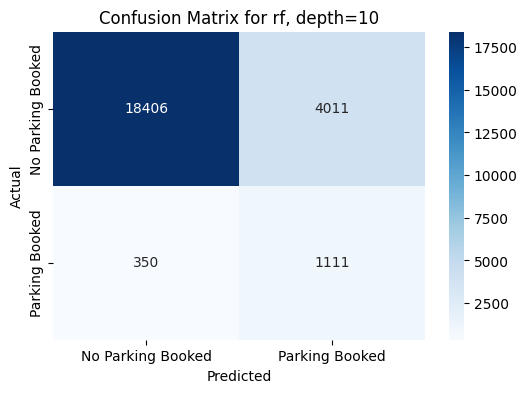

In [35]:
# Refit du meilleur modèle 3 (balanced accuracy)
pipe = Pipeline(steps=[('preprocessor', preproc), 
                       ('scaler', MaxAbsScaler()),
                       ('rf', RandomForestClassifier(class_weight='balanced',
                                                     max_depth=20,
                                                     min_samples_leaf=4,
                                                     min_samples_split=2,
                                                     n_estimators=200))
                      ])

best_model = pipe.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f_score = fbeta_score(y_test, y_pred, beta=1)
print("Recall on test:", recall)
print("Precision on test:", precision)
print("F1 score on test:", f_score)
print("Balanced accuracy on test:", balanced_accuracy)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Parking Booked', 'Parking Booked'],
            yticklabels=['No Parking Booked', 'Parking Booked'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for rf, depth=20')
plt.show()

Recall on test: 0.5961670088980151
Precision on test: 0.2807865892972276
F1 score on test: 0.3817663817663818
Balanced accuracy on test: 0.7483221626102246


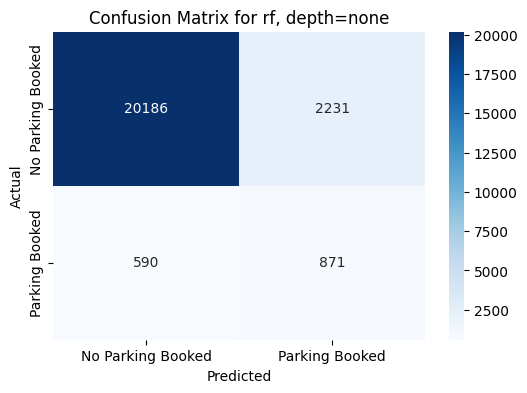

In [36]:
# Refit du meilleur modèle 4 (f score)
pipe = Pipeline(steps=[('preprocessor', preproc), 
                       ('scaler', MaxAbsScaler()),
                       ('rf', RandomForestClassifier(class_weight='balanced',
                                                     max_depth=None,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=200))
                      ])

best_model = pipe.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f_score = fbeta_score(y_test, y_pred, beta=1)
print("Recall on test:", recall)
print("Precision on test:", precision)
print("F1 score on test:", f_score)
print("Balanced accuracy on test:", balanced_accuracy)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Parking Booked', 'Parking Booked'],
            yticklabels=['No Parking Booked', 'Parking Booked'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for rf, depth=none')
plt.show()

Les meilleurs modèles sont désormais de type ```rf```, avec des paramètres différents selon qu'ils maximisent la ```balanced_accuracy``` ou le score F1. Ils prédisent la classe positive 3 à 4 fois plus souvent que le modèle ```knn```précédent : l'altération de la fonction de perte a donc bien permis d'améliorer le recall. La précision de ces trois modèles est cependant similaire : 16,7 % pour le modèle ```rf``` maximisant la ```balanced_accuracy```, 18,5 % pour le modèle ```knn``` et 19,9 % pour le modèle ```rf``` maximisant le score f1.

### Oversampling

Essayons d'améliorer les autres modèles en introduisant de l'oversampling, qui consiste à créer de nouvelles observations de la classe minoritaire jusqu'à équilibre sa fréquence avec la classe majoritaire. L'inconvénient de cette approche est qu'elle accroît substantiellement la taille du dataset, donc les temps de calcul. On la retient toutefois car ils ne sont pas encore déraisonnables (sinon, une solution serait de recourir à l'undersampling, qui consiste à réduire le nombre d'observations de la classe majoritaire). La méthode la plus simple, ```RandomOverSampler()```, consiste à dupliquer aléatoirement les observations. Elle accroît cependant beaucoup le risque d'overfitting. Nous utilisons ici la fonction ```ADASYN()```, qui génère de nouvelles observations synthétiques par la méthode des plus proches voisins, et accorde davantage d'attention aux observations les plus difficiles à prédire.

In [ ]:
# Modification de la fonction pipeline pour intégrer l'oversampling
from imblearn.pipeline import Pipeline

# Sélection des modèles
oversampled_models = [('knn', KNeighborsClassifier()),
                      ('hgbc', HistGradientBoostingClassifier()),
                      ('mlp', MLPClassifier())
]

# Définition des espaces hyperparamétriques
oversampled_grids = {'knn' : {
                         'knn__n_neighbors': [1, 2, 3, 4, 5],
                         'knn__weights': ['uniform', 'distance']},
                     'hgbc': {
                         'hgbc__learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'hgbc__max_iter': [300],
                         'hgbc__max_depth': [None, 10, 20, 30],
                         'hgbc__min_samples_leaf': [1, 5, 10, 20],
                         'hgbc__l2_regularization': [0, 0.1, 1, 10],
                         'hgbc__early_stopping': [True],
                         'hgbc__max_bins': [255]},
                     'mlp': {
                          'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100,100)],
                          'mlp__activation': ['relu', 'tanh'],
                          'mlp__learning_rate_init': [0.001, 0.01, 0.1],
                          'mlp__max_iter': [750],
                          'mlp__alpha': np.logspace(-5, -1, 5)}
}

# Recherche de la meilleure spécification
results_oversampled = []
for name, model in oversampled_models:
    pipe = Pipeline(steps=[('preprocessor', preproc), 
                           ('sampling', ADASYN(random_state=42)), # Oversampling
                           ('scaler', MaxAbsScaler()),
                           (name, model)
    ])
    clf = GridSearchCV(pipe, 
                       oversampled_grids[name], 
                       cv=3,                 
                       scoring={'positive_pred': positive_class_counter,
                                'accuracy': 'accuracy', 
                                'balanced_accuracy': 'balanced_accuracy',
                                'precision': precision_scorer,
                                'recall': 'recall',
                                'beta_score': f_beta_scorer},
                       refit=False,
                       n_jobs=-1,
                       verbose=1)
    clf.fit(X_train, y_train)
    
    df = pd.DataFrame(clf.cv_results_)
    df['model'] = name
    results_oversampled.append(df)

# Agrégation des résultats et sélection de la meilleure spécification
results_oversampled = pd.concat(results_oversampled, ignore_index=True)
results_oversampled.to_csv('results_oversampled.csv', index=False)

In [16]:
# results_oversampled = pd.read_csv("results_oversampled.csv")

In [21]:
# On affiche les performances moyennes par type de modèle type de modèle
results_oversampled.groupby('model')[['mean_test_positive_pred', 'mean_test_recall', 'mean_test_precision', 'mean_test_beta_score', 'mean_test_balanced_accuracy']].max().reset_index()

,model,mean_test_positive_pred,mean_test_recall,mean_test_precision,mean_test_beta_score,mean_test_balanced_accuracy
0,hgbc,622.666667,0.148447,0.575789,0.232191,0.569941
1,knn,4937.000000,0.445172,0.206564,0.259610,0.654696
2,mlp,24323.333333,0.926280,0.287191,0.319586,0.756626


En moyenne, les modèles ```knn``` se comportent le moins bien. Les modèles ```hgbc``` tendent à maximiser la ```balanced_accuracy``` et les modèles ```mlp``` le score f1.

In [22]:
# On affiche les 15 meilleurs modèles d'après le score f1
top_15_oversampled = results_oversampled.sort_values(by='mean_test_beta_score', ascending=False).head(15)
top_15_oversampled[['model', 'params', 'mean_test_positive_pred', 'mean_test_recall', 'mean_test_precision', 'mean_test_beta_score', 'mean_test_balanced_accuracy']].fillna("-")

,model,params,mean_test_positive_pred,mean_test_recall,mean_test_precision,mean_test_beta_score,mean_test_balanced_accuracy
377,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.1,...",3970.666667,0.480605,0.243705,0.319586,0.689776
317,mlp,"{'mlp__activation': 'relu', 'mlp__alpha': 0.1,...",3033.333333,0.403862,0.265516,0.319504,0.664553
374,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.1,...",3655.000000,0.455080,0.247905,0.319124,0.681452
375,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.1,...",4172.333333,0.491016,0.234305,0.316655,0.691950
314,mlp,"{'mlp__activation': 'relu', 'mlp__alpha': 0.1,...",3232.000000,0.410243,0.253490,0.311845,0.664628
318,mlp,"{'mlp__activation': 'relu', 'mlp__alpha': 0.1,...",4191.333333,0.470865,0.226884,0.301642,0.680886
315,mlp,"{'mlp__activation': 'relu', 'mlp__alpha': 0.1,...",5380.000000,0.549958,0.210697,0.300316,0.703153
384,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.1,...",4381.333333,0.482788,0.223867,0.296951,0.684062
379,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.1,...",5308.333333,0.543577,0.209156,0.294825,0.700951
363,mlp,"{'mlp__activation': 'tanh', 'mlp__alpha': 0.01...",3329.666667,0.395130,0.235212,0.294747,0.654933


In [23]:
# Sélection du meilleur modèle
best_oversampled_model_idx = results_oversampled['mean_test_balanced_accuracy'].idxmax()
best_oversampled_model_row = results_oversampled.loc[best_oversampled_model_idx]
print("Best result based on balanced accuracy on test:")
print(best_model_row[['model', 'mean_test_positive_pred', 'mean_test_accuracy', 'mean_test_balanced_accuracy', 'mean_test_beta_score']])
print(best_oversampled_model_row['params'])
print("\n")

best_oversampled_model_idx = results_oversampled['mean_test_beta_score'].idxmax()
best_oversampled_model_row = results_oversampled.loc[best_oversampled_model_idx]
print("Best result based on beta score on test:")
print(best_model_row[['model', 'mean_test_positive_pred', 'mean_test_accuracy', 'mean_test_balanced_accuracy', 'mean_test_beta_score']])
print(best_oversampled_model_row['params'])

Best result based on balanced accuracy on test:
model                                  mlp
mean_test_positive_pred        1678.666667
mean_test_accuracy                0.912147
mean_test_balanced_accuracy       0.588294
mean_test_beta_score              0.235974
Name: 402, dtype: object
{'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100, 100), 'mlp__learning_rate_init': 0.1, 'mlp__max_iter': 750}


Best result based on beta score on test:
model                                  mlp
mean_test_positive_pred        1678.666667
mean_test_accuracy                0.912147
mean_test_balanced_accuracy       0.588294
mean_test_beta_score              0.235974
Name: 402, dtype: object
{'mlp__activation': 'tanh', 'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (100,), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 750}


Recall on test: 0.4483230663928816
Precision on test: 0.2137030995106036
F1 score on test: 0.2894387980556783
Balanced accuracy on test: 0.67040768567001


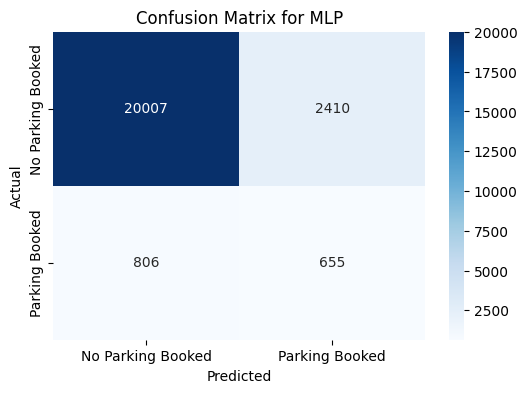

In [37]:
# Refit du meilleur modèle 5 (balanced accuracy)
pipe = Pipeline(steps=[('preprocessor', preproc),
                       ('sampling', ADASYN(random_state=42)),
                       ('scaler', MaxAbsScaler()),
                       ('mlp', MLPClassifier(
                           activation='relu',
                           alpha=0.01,
                           hidden_layer_sizes=(100,100),
                           learning_rate_init=0.1,
                           max_iter=750))
                        ])

best_model = pipe.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f_score = fbeta_score(y_test, y_pred, beta=1)
print("Recall on test:", recall)
print("Precision on test:", precision)
print("F1 score on test:", f_score)
print("Balanced accuracy on test:", balanced_accuracy)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Parking Booked', 'Parking Booked'],
            yticklabels=['No Parking Booked', 'Parking Booked'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for MLP')
plt.show()

Recall on test: 0.4839151266255989
Precision on test: 0.2525
F1 score on test: 0.3318469842759916
Balanced accuracy on test: 0.6952742426186833


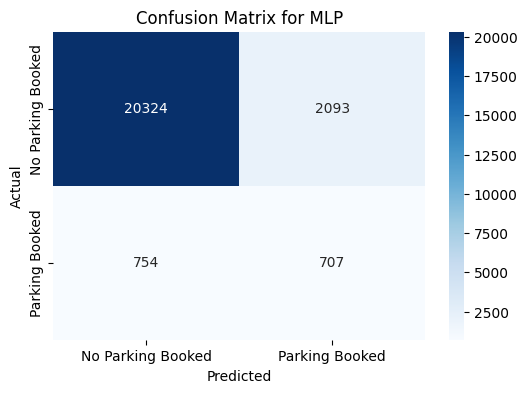

In [61]:
# Refit du meilleur modèle 6 (f score)
pipe = Pipeline(steps=[('preprocessor', preproc),
                       ('sampling', ADASYN(random_state=42)),
                       ('scaler', MaxAbsScaler()),
                       ('mlp', MLPClassifier(
                           activation='tanh',
                           alpha=0.1,
                           hidden_layer_sizes=(100,),
                           learning_rate_init=0.001,
                           max_iter=750))
                       ])

best_model = pipe.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f_score = fbeta_score(y_test, y_pred, beta=1)
print("Recall on test:", recall)
print("Precision on test:", precision)
print("F1 score on test:", f_score)
print("Balanced accuracy on test:", balanced_accuracy)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Parking Booked', 'Parking Booked'],
            yticklabels=['No Parking Booked', 'Parking Booked'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for MLP')
plt.show()

Les modèles sélectionnés sont de type ```MLP``` et ```HGBC```. Nous constatons que l'oversampling, comme l'altération des fonctions de perte, a permis d'améliorer substantiellement la performance prédictive de ces modèles pour la classe minoritaire.

## Conclusion
Il est difficile de choisir un modèle optimal parmi les précédents, car leur comportement semble en réalité très similaire : le recall évolue en sens inverse de la précision, d'une manière qui paraît globalement stable, comme en témoigne la proximité des scores f1 entre les modèles. Cela suggère que ces derniers évoluent sur une même courbe représentant le plafond global des performances atteignables sur le dataset. Confirmons cette intuition en traçant la courbe recall-precision pour l'ensemble des modèles estimés.

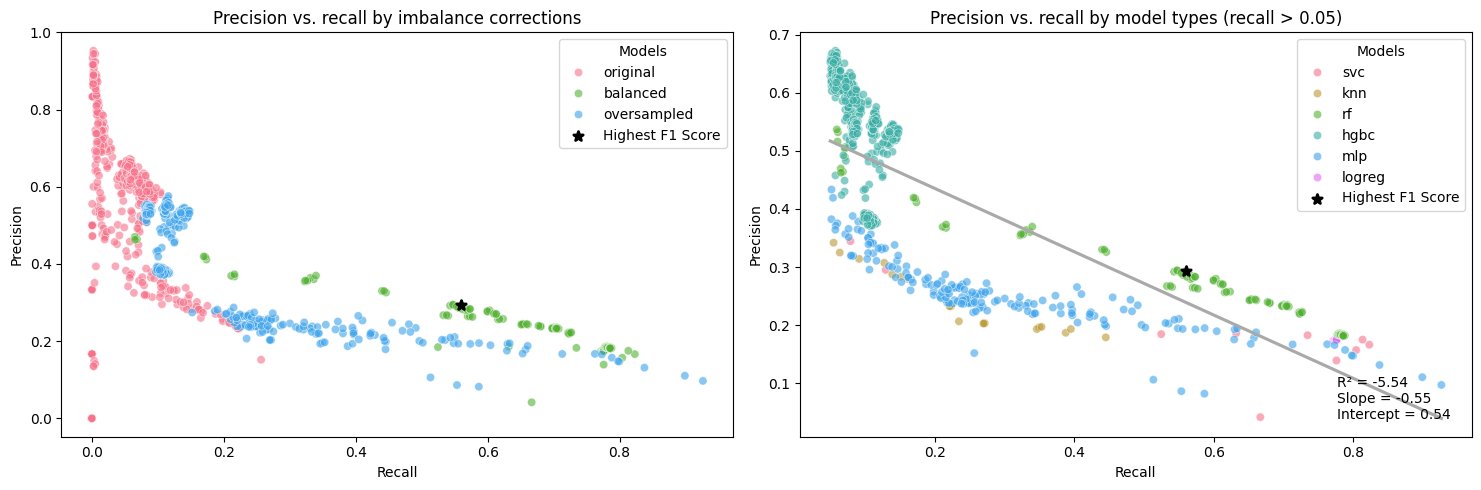

In [43]:
results['series'] = 'no imbalance correction'
results_balanced['series'] = 'class-weighting'
results_oversampled['series'] = 'oversampling'

combined_results = pd.concat([results, results_balanced, results_oversampled], ignore_index=True)
combined_results_subset = combined_results[combined_results['mean_test_recall'] > 0.05]

max_ba_row = combined_results_subset.loc[combined_results_subset['mean_test_balanced_accuracy'].idxmax()]
max_f1_row = combined_results_subset.loc[combined_results_subset['mean_test_beta_score'].idxmax()]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(
    x='mean_test_recall',
    y='mean_test_precision',
    hue='series',
    data=combined_results,
    palette=sns.color_palette('husl', 3),
    alpha=0.6)
plt.scatter(
    x=max_ba_row['mean_test_recall'],
    y=max_ba_row['mean_test_precision'],
    color='black',
    s=50,
    marker='+',
    linewidths=2,
    label='Highest balanced accuracy'
)
plt.scatter(
    x=max_f1_row['mean_test_recall'],
    y=max_f1_row['mean_test_precision'],
    color='black',
    s=50,
    marker='*',
    linewidths=2,
    label='Highest F1 Score'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. recall by imbalance corrections')
plt.legend(title='')

plt.subplot(1, 2, 2)
sns.scatterplot(
    x='mean_test_recall',
    y='mean_test_precision',
    hue='model',
    data=combined_results_subset,
    palette=sns.color_palette('husl', 6),
    alpha=0.6
)
sns.regplot(
    x='mean_test_recall',
    y='mean_test_precision',
    data=combined_results_subset,
    scatter=False,
    color='darkgray',
    ci=None)
plt.scatter(
    x=max_ba_row['mean_test_recall'],
    y=max_ba_row['mean_test_precision'],
    color='black',
    s=50,
    marker='+',
    linewidths=2,
    label='Highest balanced accuracy'
)
plt.scatter(
    x=max_f1_row['mean_test_recall'],
    y=max_f1_row['mean_test_precision'],
    color='black',
    s=50,
    marker='*',
    linewidths=2,
    label='Highest F1 Score'
)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision vs. recall by model types (recall > 0.05)')
plt.legend(title='')

slope, intercept = np.polyfit(combined_results_subset['mean_test_recall'], combined_results_subset['mean_test_precision'], 1)
r2 = r2_score(combined_results_subset['mean_test_precision'], combined_results_subset['mean_test_recall'])
plt.text(0.80, 0.15, f'R² = {r2:.2f}\nSlope = {slope:.2f}\nIntercept = {intercept:.2f}', transform=plt.gca().transAxes, ha='left', va='top')

plt.tight_layout()
plt.savefig('precision_recall_all.png', format='png')
plt.show()

En négligeant les modèles les moins performants, on observe effectivement une relation quasi-linéaire entre le recall et la précision. Il est donc impossible de maximiser simultanément ces deux indicateurs de performance. Cela signifie qu'il est impossible de choisir univoquement un modèle : presque tous les modèles explorés, après correction du déséquilibre du dataset, recouvrent un compromis équivalent entre les deux critères de décision qui nous intéressent. Pour trancher, il fautdrait...
- Soit apporter une information supplémentaire, comme le nombre de SMS que la direction de l'hôtel envisage d'envoyer. Pour $n=3500$, c'est par exemple le modèle ```HGBC``` que nous retiendrons.
- Soit calculer pour chaque modèle le profit espéré de l'envoi des SMS, calculé en fonction du coût d'envoi des SMS, du tarif de stationnement et de la durée des séjours. Nous allons le faire plus finement par la suite.

## Modèle probabiliste simple

Le principe ici est d'utiliser les probabilités d'appartenance à chaque classe plutôt que les classes prédites. Il y a deux justifications à cela :
1. Utiliser les classes prédites revient à considérer qu'un individu réservera une place de parking si sa probabilité prédite est supérieure à 0,5 (puisqu'il s'agit d'une classification binaire). Mais ce seuil d'attribution à la classe positive est arbitraire, et rien n'interdit d'utiliser une valeur inférieure. Après tout, il n'est pas étonnant que les probabilités prédites soient faibles, si les individus les plus susceptibles de réserver une place de parking l'on déjà fait.
2. Utiliser les probabilités prédites permet d'individualiser le calcul du profit espéré et les décisions d'envoyer des SMS. L'intérêt de cette approche est que les clients diffèrent par leur probabilité de réserver une place de parking, mais aussi par leur durée de séjour, qui détermine directement le profit réalisé grâce à cette réservation. Il peut donc être pertinent d'envoyer des SMS à des clients dont la probabilité de réponse est faible mais le séjour est long, plutôt qu'à des clients dont la probabilité de réponse est forte mais le séjour est bref.

Pour illustrer cette approche, repartons du modèle logistique initial. Nous ne réutilisons pas le modèle optimal sélectionné précédemment (la classe ```HGBC``` permet bien de calculer les probabilités prédites) pour ne pas s'exposer à une quelconque déformation de la structure des probabilités, entraînée par l'oversampling. Nous n'introduisons pas de scaling pour la même raison. Il s'agit de la démarche recommandée ici par exemple : https://pastorjordi.github.io/blog/2022/balance_weights_logreg/

Pour calculer le profit espéré, nous supposons un coût de 1€ pour l'envoi d'un SMS de une marge de 5€ par journée de stationnement. Ces valeurs sont volontairement assez proches ; si elles étaient plus éloignées, le résultat probable serait de contacter tous les clients, si elles étaient très proches, de n'en contacter aucun.

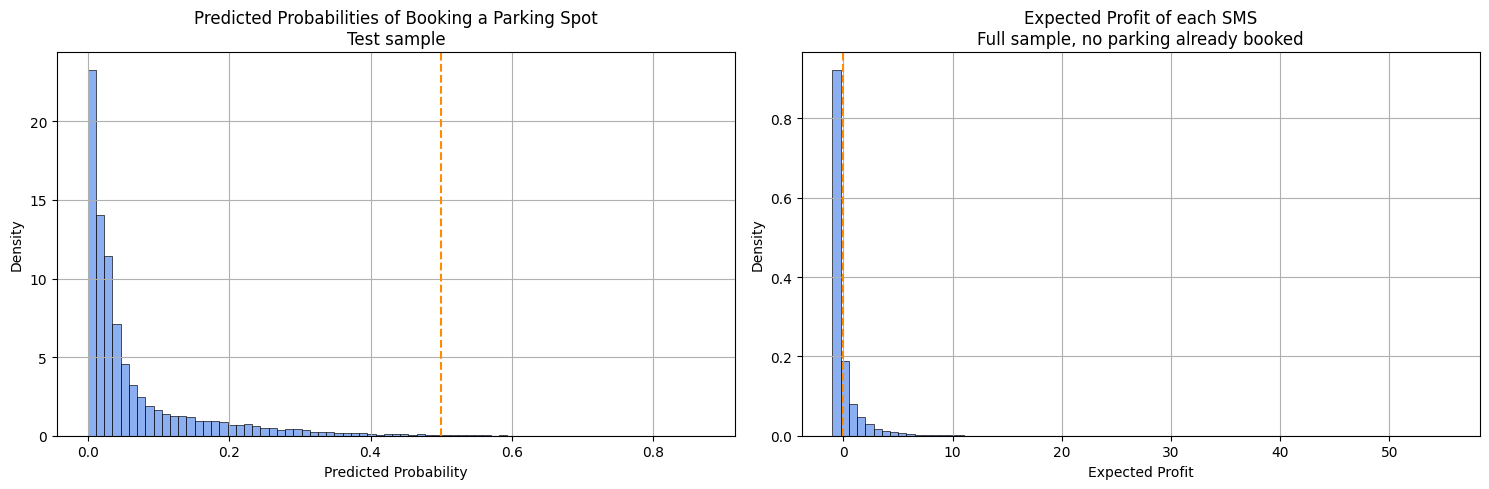

In [7]:
sms_cost = 1
parking_price = 5

# Refit du modèle
pipe = Pipeline([('preprocessor', preproc), 
                 ('logreg', LogisticRegression(C=1024, max_iter=15000))])
logreg_model = pipe.fit(X_train, y_train)

# Calcul des probabilités prédites sur l'échantillon de test
y_proba_test = logreg_model.predict_proba(X_test)[:, 1]

# Calcul du profit espéré sur l'ensemble des données (pour les individus n'ayant pas déjà réservé une place)
filtered_data = data[data['required_car_parking_spaces'] == 0]
y_proba = logreg_model.predict_proba(filtered_data)[:, 1]
filtered_data['predicted_proba'] = y_proba
filtered_data['expected_gain'] = y_proba * (filtered_data['stays_in_weekend_nights'] + filtered_data['stays_in_week_nights']) * parking_price - sms_cost
filtered_data = filtered_data.sort_values(by='expected_gain', ascending=False).reset_index(drop=True)

# Représentation graphique
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_proba_test, bins=75, kde=False, color='cornflowerblue', stat='density')
plt.title('Predicted Probabilities of Booking a Parking Spot\nTest sample')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.axvline(x=0.5, color='darkorange', linestyle='--')
plt.grid()

plt.subplot(1, 2, 2)
sns.histplot(filtered_data['expected_gain'], bins=75, kde=False, color='cornflowerblue', stat='density')
plt.title('Expected Profit of each SMS\nFull sample, no parking already booked')
plt.xlabel('Expected Profit')
plt.ylabel('Density')
plt.axvline(x=0, color='darkorange', linestyle='--')
plt.grid()

plt.tight_layout()
plt.savefig('predicted_probas.png', format='png')
plt.show()

On retrouve bien des probabilités prédites quasi-systématiquement inférieures à 0,5. On observe aussi que leur distribution présente une queue épaisse entre 0,1 et 0,35. On peut finalement déterminer les individus auxquels envoyer un SMS, pour lesquels l'espérance de profit est positive. Pour le profit espéré, on observe une majorité de valeurs négatives, et une queue de distribution beaucoup plus étalée. Ceci atteste de l'intérêt de ternir compte de la durée des réservations dans la décision d'envoyer des SMS.

In [8]:
# On crée une variable binaire pour l'envoi de SMS
filtered_data['send_sms'] = np.where(filtered_data['expected_gain'] > 0, 'YES', 'NO')

# Affichage des résultats
sms_to_send = filtered_data[filtered_data['send_sms'] == 'YES'].shape[0]
total_gain = filtered_data[filtered_data['send_sms'] == 'YES']['expected_gain'].sum()

print("Number of SMS to send:", sms_to_send)
print(f"Total expected profit: {total_gain:.1f} €")

Number of SMS to send: 27266
Total expected profit: 45926.1 €


La conclusion est que l'envoi de SMS serait rentable en moyenne pour environ de 32 000 clients, et pourrait rapporter un peu moins de 48 000 €. 

Cela montre que la régression logistique est parfaitement utilisable, même si ses premiers résultats ne l'étaient pas. Comparons pour finir ses performances avec celles des modèles optimisés précédemment. Une première manière de le faire est de représenter des matrices de confusion avec des seuils d'attribution à la classe positive inférieurs à 0,5.

In [17]:
# Extraction des probabilités prédites
X_test['predicted_prob'] = logreg_model.predict_proba(X_test)[:, 1]

# Création d'indicatrices des classes prédites avec différents seuils pour les probabilités prédites
X_test['predict_005'] = (X_test['predicted_prob'] > 0.05).astype(int)
X_test['predict_015'] = (X_test['predicted_prob'] > 0.1232).astype(int)
X_test['predict_025'] = (X_test['predicted_prob'] > 0.166).astype(int)

# Calcul des scores
recall_005 = recall_score(y_test, X_test['predict_005'])
recall_015 = recall_score(y_test, X_test['predict_015'])
recall_025 = recall_score(y_test, X_test['predict_025'])
precision_005 = precision_score(y_test, X_test['predict_005'])
precision_015 = precision_score(y_test, X_test['predict_015'])
precision_025 = precision_score(y_test, X_test['predict_025'])
f_score_005 = fbeta_score(y_test, X_test['predict_005'], beta=1)
f_score_015 = fbeta_score(y_test, X_test['predict_015'], beta=1)
f_score_025 = fbeta_score(y_test, X_test['predict_025'], beta=1)
balanced_accuracy_005 = balanced_accuracy_score(y_test, X_test['predict_005'])
balanced_accuracy_015 = balanced_accuracy_score(y_test, X_test['predict_015'])
balanced_accuracy_025 = balanced_accuracy_score(y_test, X_test['predict_025'])

# Affichage des résultats
print("p > 0.05")
print(f"Recall: {recall_005:.3f}")
print(f"Precision: {precision_005:.3f}")
print(f"F1 score: {f_score_005:.3f}")
print(f"Balanced accuracy: {balanced_accuracy_005:.3f}")
print("Confusion matrix:")
print(pd.crosstab(y_test, X_test['predict_005']))
print("\n")

print("p > 0.1232")
print(f"Recall: {recall_015:.3f}")
print(f"Precision: {precision_015:.3f}")
print(f"F1 score: {f_score_015:.3f}")
print(f"Balanced accuracy: {balanced_accuracy_015:.3f}")
print("Confusion matrix:")
print(pd.crosstab(y_test, X_test['predict_015']))
print("\n")

print("p > 0.1888")
print(f"Recall: {recall_025:.3f}")
print(f"Precision: {precision_025:.3f}")
print(f"F1 score: {f_score_025:.3f}")
print(f"Balanced accuracy: {balanced_accuracy_025:.3f}")
print("Confusion matrix:")
print(pd.crosstab(y_test, X_test['predict_025']))

p > 0.05
Recall: 0.840
Precision: 0.155
F1 score: 0.262
Balanced accuracy: 0.771
Confusion matrix:
predict_005                      0     1
required_car_parking_spaces             
0                            15746  6671
1                              234  1227


p > 0.1232
Recall: 0.596
Precision: 0.223
F1 score: 0.325
Balanced accuracy: 0.730
Confusion matrix:
predict_015                      0     1
required_car_parking_spaces             
0                            19381  3036
1                              590   871


p > 0.1888
Recall: 0.484
Precision: 0.253
F1 score: 0.332
Balanced accuracy: 0.695
Confusion matrix:
predict_025                      0     1
required_car_parking_spaces             
0                            20328  2089
1                              754   707


Best model = 4 = RF
- 20186 -> 2231
- 590 -> 871
- RRecall on test: 0.5961670088980151
- Precision on test: 0.2807865892972276
- F1 score on test: 0.3817663817663818
- Balanced accuracy on test: 0.7483221626102246

Another model = 6 = MLP
- 20324 -> 2093
- 754 -> 707
- Recall on test: 0.4839151266255989
- Precision on test: 0.2525
- F1 score on test: 0.3318469842759916
- Balanced accuracy on test: 0.6952742426186833

On constate qu'utiliser un seuil d'attribution...
- De 0.1285 aboutit à des performances comparables à celles de notre meilleur modèle (```HGBC```) (avec autant de vrais positifs et de faux négatifs, mais 50 faux positifs supplémentaires)
- De 0.1949 aboutit à de bien meilleures performances que celles de notre second meilleur modèle (```knn```) (avec autant de vrais positifs et de faux négatifs, mais 500 faux positifs en moins)

Ce résultat est intéressant : optimiser le type et les spécifications des modèles, et compenser le déséquilibre du dataset, ne permet pas de retrouver des informations qui ne sont pas déjà présentes dans un modèle logistique élémentaire. Autrement dit, ce modèle permet d'approcher directement le plafond de performance dont nous avons constaté l'existence. Nous pouvons le confirmer en traçant la courbe precision-recall de la régression logistique (qui est fonction du seuil d'attribution).

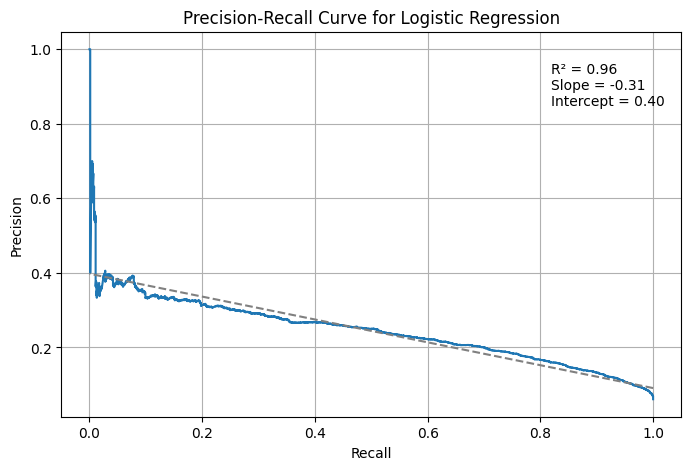

In [32]:
y_proba = logreg_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(8, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.grid()

slope, intercept = np.polyfit(recall, precision, 1)
regression_line = slope * recall + intercept
plt.plot(recall, regression_line, color='gray', linestyle='--', label=f'Regression Line (Slope = {slope:.2f})')
r2 = r2_score(precision, regression_line)
plt.text(0.79, 0.80, f'R² = {r2:.2f}\nSlope = {slope:.2f}\nIntercept = {intercept:.2f}', transform=plt.gca().transAxes, ha='left', va='bottom')

plt.savefig('predicision_recall_logreg.png', format='png')
plt.show()

La courbe obtenue est très proche de la précédente (après élimination des modèles mal-spécifiés sur la gauche, dont le recall est nul ou presque) : elle suit une droite de régression de pente -0,24 et d'intercept 0,33, contre -0,16 et 0,29 précédemment. Nos efforts d'optimisation ont seulement permis de ralentir un peu le trade-off entre recall et precision.

In [ ]:
sms_cost = 1
parking_price = 5

# Refit du modèle
pipe = Pipeline([('preprocessor', preproc), 
                 ('rf', RandomForestClassifier(class_weight='balanced',
                                                     max_depth=None,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5,
                                                     n_estimators=200))])

logreg_model = pipe.fit(X_train, y_train)

# Calcul des probabilités prédites sur l'échantillon de test
y_proba_test = logreg_model.predict_proba(X_test)[:, 1]

# Calcul du profit espéré sur l'ensemble des données (pour les individus n'ayant pas déjà réservé une place)
filtered_data = data[data['required_car_parking_spaces'] == 0]
y_proba = logreg_model.predict_proba(filtered_data)[:, 1]
filtered_data['predicted_proba'] = y_proba
filtered_data['expected_gain'] = y_proba * (filtered_data['stays_in_weekend_nights'] + filtered_data['stays_in_week_nights']) * parking_price - sms_cost
filtered_data = filtered_data.sort_values(by='expected_gain', ascending=False).reset_index(drop=True)

# Représentation graphique
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(y_proba_test, bins=75, kde=False, color='cornflowerblue', stat='density')
plt.title('Predicted Probabilities of Booking a Parking Spot\nTest sample')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.axvline(x=0.5, color='darkorange', linestyle='--')
plt.grid()

plt.subplot(1, 2, 2)
sns.histplot(filtered_data['expected_gain'], bins=75, kde=False, color='cornflowerblue', stat='density')
plt.title('Expected Profit of each SMS\nFull sample, no parking already booked')
plt.xlabel('Expected Profit')
plt.ylabel('Density')
plt.axvline(x=0, color='darkorange', linestyle='--')
plt.grid()

plt.tight_layout()
plt.savefig('predicted_probas.png', format='png')
plt.show()